In [1]:
## Q2 ##
#part 4#
# sun effect on orbital elements #

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.integrate import ode
from scipy.optimize import fsolve
from scipy.optimize import root
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
from scipy.optimize import basinhopping
from scipy.optimize import brute
from scipy.optimize import fmin
from scipy.optimize import fminbound

import time
import math
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.spatial.transform import Rotation
from skyfield.api import load
from skyfield.api import load
from astropy import units as u


In [2]:
# orbital elements #
a = 6783.34174
e = 0.0014021
i = 51.27632*np.pi/180 # rad
omega = 90.69731*np.pi/180 # rad
Omega = 275.17058*np.pi/180 # rad
theta = 309.67626*np.pi/180 # rad

# calculate other needed parameter #
mu = 398600.4415 # km^3/s^2
R_e = 6378.1363 # km
J2 = 0.0010826269
n = np.sqrt(mu/a**3) # rad/s
h = np.sqrt(mu*a*(1-e**2)) # km^2/s
p = a*(1-e**2) # km
r = p/(1+e*np.cos(theta)) # km



In [3]:
# Load the JPL ephemeris
eph = load('de440s.bsp')
# load time
ts = load.timescale()

# Define the time of interest
t = ts.utc(2023, 8, 1, 15, 0, 0)

# check time
print(t.utc_strftime('On %Y %b %d at %H:%M:%S'))

# Get the position of the Earth at the given time
earth = eph['Earth'].at(t)

On 2023 Aug 01 at 15:00:00


In [4]:
def orbital_element2cartesian(h, mu, e, nu, omega, Omega):
    r_w = h ** 2 / mu / (1 + e * np.cos(nu)) * np.array((np.cos(nu), np.sin(nu), 0))
    v_w = mu / h * np.array((-np.sin(nu), e + np.cos(nu), 0))

    R = Rotation.from_euler("ZXZ", [-omega, -i, -Omega])
    r_rot = r_w @ R.as_matrix()
    v_rot = v_w @ R.as_matrix()

    return [r_rot[0], r_rot[1], r_rot[2], v_rot[0], v_rot[1], v_rot[2]]


def cartesian2orbital_element(r_in, v_in):

    r_vec = np.array(r_in)  # km
    v_vec = np.array(v_in)  # km/s
    mu = 3.986e5  # km^3/s^2

    r = np.linalg.norm(r_vec)
    v = np.linalg.norm(v_vec)
    v_r = np.dot(r_vec / r, v_vec)
    v_p = np.sqrt(v ** 2 - v_r ** 2)

    h_vec = np.cross(r_vec, v_vec)
    h = np.linalg.norm(h_vec)
    i = np.arccos(h_vec[2] / h)
    K = np.array((0, 0, 1))
    N_vec = np.cross(K, h_vec)
    N = np.linalg.norm(N_vec)
    Omega = 2 * np.pi - np.arccos(N_vec[0] / N)
    K = np.array((0, 0, 1))
    N_vec = np.cross(K, h_vec)
    N = np.linalg.norm(N_vec)
    Omega = 2 * np.pi - np.arccos(N_vec[0] / N)
    # [section-5]
    e_vec = np.cross(v_vec, h_vec) / mu - r_vec / r
    e = np.linalg.norm(e_vec)
    omega = 2 * np.pi - np.arccos(np.dot(N_vec, e_vec) / (N * e))
    nu = np.arccos(np.dot(r_vec / r, e_vec / e))
    # semi-major axis
    a = h**2/mu * (1/(1+e) + 1/(1-e)) / 2 

    return [a, e, i, omega, Omega, nu]


In [5]:
# Load the JPL ephemeris
# load time
ts = load.timescale()
mu_sun = 1.32712440018e11
# Define the time of interest
# orbit propafation with moon third-body #
def relative_motion_tbp(t, Y):
    """Calculate the motion of a three-body system relative to $m_1$.

    The state vector ``Y`` should be in the order:

    1. Coordinates of $m_2$ relative to $m_1$
    2. Velocity components of $m_2$ relative to $m_1$
    """
    # Get the three position components
    r_vec = Y[:3]

    # Create the derivative vector and copy the velocities into it
    Ydot = np.zeros_like(Y)
    Ydot[:3] = Y[3:]

    utc_time = ts.utc(2022, 4, 30, 12, 0, 0)

    utc_time += 1/3600/24*t
    r_earth = eph['Earth'].at(utc_time)
    r_earth = r_earth.position.km
    r_sun = eph['Sun'].at(utc_time)
    r_sun = r_sun.position.km
    r_vec_sun = r_sun - r_earth
    # Calculate the accelerations
    r = np.sqrt(np.sum(np.square(r_vec)))
    a_vec = -mu * r_vec / r ** 3 + mu_sun * (r_vec - r_vec_sun) / np.sqrt(np.sum(np.square(r_vec - r_vec_sun))) ** 3
    Ydot[3:] = a_vec

    return Ydot



In [6]:
Y_0 = orbital_element2cartesian(h, mu, e, theta, omega, Omega)
t_0 = 0  # seconds
t_f = 100  # seconds
t_points = np.linspace(t_0, t_f, 1000)
sol = solve_ivp(relative_motion_tbp, [t_0, t_f], Y_0, t_eval=t_points)

In [7]:
## change cartesian to orbital element for all propagation $$
orbital_elemnt = np.zeros((len(sol.t), 6))
for i in range(len(sol.t)):
    orbital_elemnt[i] = cartesian2orbital_element(sol.y[:3, i], sol.y[3:, i])


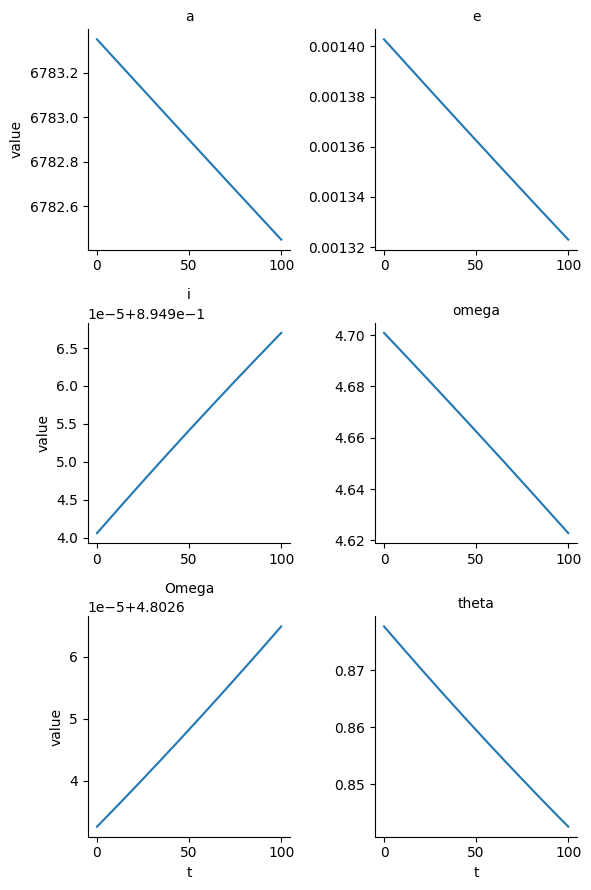

In [8]:
# plot results with seaborn # a, e, i, omega, Omega, theta
df = pd.DataFrame(orbital_elemnt, columns=['a', 'e', 'i', 'omega', 'Omega', 'theta'])
df['t'] = sol.t
df = pd.melt(df, id_vars=['t'], value_vars=['a', 'e', 'i', 'omega', 'Omega', 'theta'])
g = sns.FacetGrid(df, col='variable', col_wrap=2, sharex=False, sharey=False)
g.map(plt.plot, 't', 'value')
g.set_titles('{col_name}')
g.set_xlabels('t')
g.set_ylabels('value')

# save fig as eps #
plt.savefig('../../Figure/Q2/orbital_elements_variation_sun_100.eps', format='eps', dpi=1000)

In [9]:
Y_0 = orbital_element2cartesian(h, mu, e, theta, omega, Omega)
t_0 = 0  # seconds
t_f = 5000  # seconds
t_points = np.linspace(t_0, t_f, 1000)
sol = solve_ivp(relative_motion_tbp, [t_0, t_f], Y_0, t_eval=t_points)

In [10]:
## change cartesian to orbital element for all propagation $$
orbital_elemnt = np.zeros((len(sol.t), 6))
for i in range(len(sol.t)):
    orbital_elemnt[i] = cartesian2orbital_element(sol.y[:3, i], sol.y[3:, i])


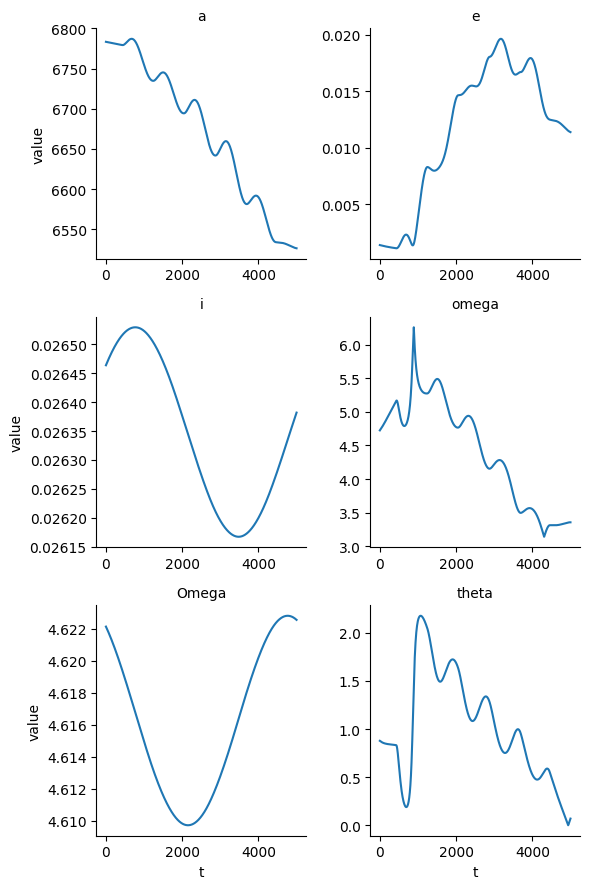

In [11]:
# plot results with seaborn # a, e, i, omega, Omega, theta
df = pd.DataFrame(orbital_elemnt, columns=['a', 'e', 'i', 'omega', 'Omega', 'theta'])
df['t'] = sol.t
df = pd.melt(df, id_vars=['t'], value_vars=['a', 'e', 'i', 'omega', 'Omega', 'theta'])
g = sns.FacetGrid(df, col='variable', col_wrap=2, sharex=False, sharey=False)
g.map(plt.plot, 't', 'value')
g.set_titles('{col_name}')
g.set_xlabels('t')
g.set_ylabels('value')

# save fig as eps #
plt.savefig('../../Figure/Q2/orbital_elements_variation_sun_5000.eps', format='eps', dpi=1000)

In [12]:
Y_0 = orbital_element2cartesian(h, mu, e, theta, omega, Omega)
t_0 = 0  # seconds
t_f = 10000  # seconds
t_points = np.linspace(t_0, t_f, 1000)
sol = solve_ivp(relative_motion_tbp, [t_0, t_f], Y_0, t_eval=t_points)

In [13]:
## change cartesian to orbital element for all propagation $$
orbital_elemnt = np.zeros((len(sol.t), 6))
for i in range(len(sol.t)):
    orbital_elemnt[i] = cartesian2orbital_element(sol.y[:3, i], sol.y[3:, i])

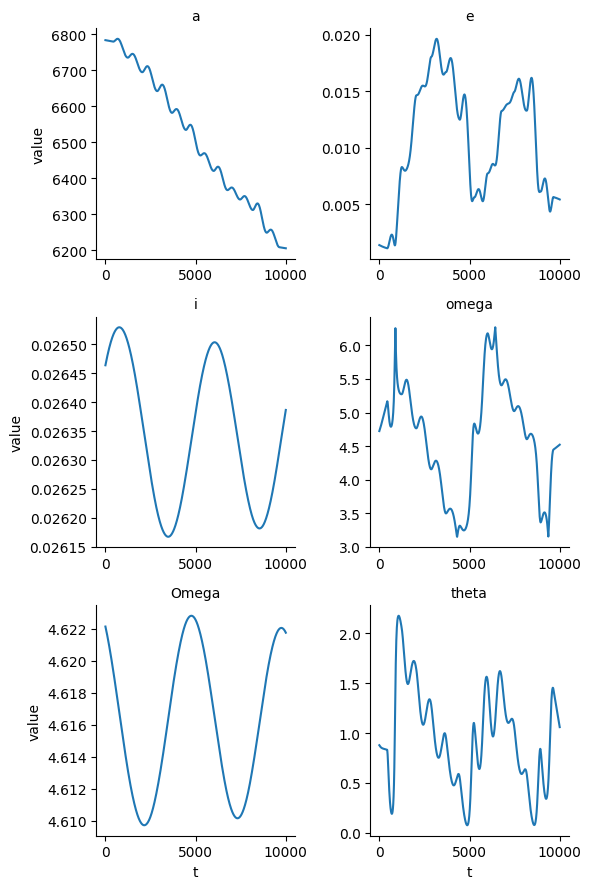

In [14]:
# plot results with seaborn # a, e, i, omega, Omega, theta
df = pd.DataFrame(orbital_elemnt, columns=['a', 'e', 'i', 'omega', 'Omega', 'theta'])
df['t'] = sol.t
df = pd.melt(df, id_vars=['t'], value_vars=['a', 'e', 'i', 'omega', 'Omega', 'theta'])
g = sns.FacetGrid(df, col='variable', col_wrap=2, sharex=False, sharey=False)
g.map(plt.plot, 't', 'value')
g.set_titles('{col_name}')
g.set_xlabels('t')
g.set_ylabels('value')

# save fig as eps #
plt.savefig('../../Figure/Q2/orbital_elements_variation_sun_10000.eps', format='eps', dpi=1000)

In [15]:
Y_0 = orbital_element2cartesian(h, mu, e, theta, omega, Omega)
t_0 = 0  # seconds
t_f = 100000  # seconds
t_points = np.linspace(t_0, t_f, 1000)
sol = solve_ivp(relative_motion_tbp, [t_0, t_f], Y_0, t_eval=t_points)

In [16]:
## change cartesian to orbital element for all propagation $$
orbital_elemnt = np.zeros((len(sol.t), 6))
for i in range(len(sol.t)):
    orbital_elemnt[i] = cartesian2orbital_element(sol.y[:3, i], sol.y[3:, i])


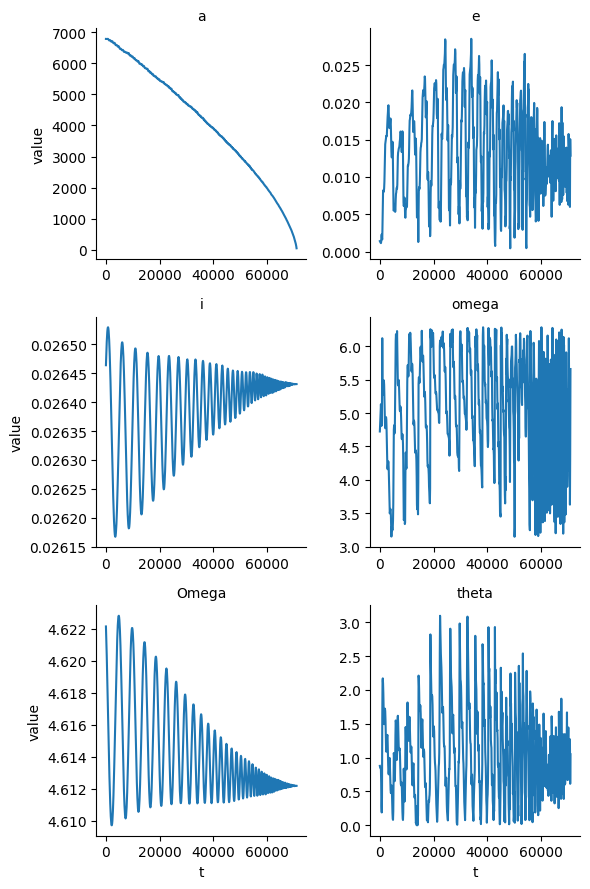

In [17]:
# plot results with seaborn # a, e, i, omega, Omega, theta
df = pd.DataFrame(orbital_elemnt, columns=['a', 'e', 'i', 'omega', 'Omega', 'theta'])
df['t'] = sol.t
df = pd.melt(df, id_vars=['t'], value_vars=['a', 'e', 'i', 'omega', 'Omega', 'theta'])
g = sns.FacetGrid(df, col='variable', col_wrap=2, sharex=False, sharey=False)
g.map(plt.plot, 't', 'value')
g.set_titles('{col_name}')
g.set_xlabels('t')
g.set_ylabels('value')

# save fig as eps #
plt.savefig('../../Figure/Q2/orbital_elements_variation_sun_100000.eps', format='eps', dpi=1000)